In [17]:
# Required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.optimize import linprog
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from statsmodels.tsa.arima.model import ARIMA
from textblob import TextBlob
from sklearn.metrics.pairwise import cosine_similarity


#### Data loading & initial processing

In [2]:
# Load the datasets
customers_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\customer_data.csv')
transactions_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\transaction_data.csv')
campaigns_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\campaign_data.csv')
products_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\product_data.csv')
behavioral_df = pd.read_csv(r'E:\ai_optimized_promotional_campaign_roi_analysis\data\behavioral_data.csv')

# Convert date columns
date_columns = {
    'transactions_df': ['transaction_date'],
    'campaigns_df': ['start_date', 'end_date'],
    'behavioral_df': ['event_date']
}

for df_name, columns in date_columns.items():
    for col in columns:
        locals()[df_name][col] = pd.to_datetime(locals()[df_name][col])

#### Analysis Framework

##### A. Customer Sagement Analysis: RFM Analysis

In [3]:
def calculate_rfm_metrics(transactions_df, end_date=None):
    """
    Calculate RFM metrics and scores for customer segmentation.
    """
    # Ensure transaction_date is datetime
    transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
    
    # Set end_date if not provided
    if end_date is None:
        end_date = transactions_df['transaction_date'].max()
    
    # Calculate base RFM metrics
    rfm = transactions_df.groupby('customer_id').agg({
        'transaction_date': lambda x: (end_date - x.max()).days,  # Recency
        'transaction_id': 'count',  # Frequency
        'final_amount': ['sum', 'mean']  # Monetary (total and average)
    })
    
    # Flatten column names
    rfm.columns = ['recency', 'frequency', 'monetary_total', 'monetary_avg']
    
    # Calculate RFM scores (1-5 scale, 5 being best)
    rfm['R_score'] = pd.qcut(rfm['recency'], q=5, labels=[5, 4, 3, 2, 1])
    rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    rfm['M_score'] = pd.qcut(rfm['monetary_total'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    
    # Calculate overall RFM Score
    rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
    
    # Add customer segments
    def segment_customers(row):
        if row['R_score'] >= 4 and row['F_score'] >= 4 and row['M_score'] >= 4:
            return 'Champions'
        elif row['R_score'] >= 3 and row['F_score'] >= 3 and row['M_score'] >= 3:
            return 'Loyal Customers'
        elif row['R_score'] >= 4 and row['F_score'] <= 2:
            return 'New Customers'
        elif row['R_score'] <= 2 and row['F_score'] <= 2 and row['M_score'] <= 2:
            return 'Lost Customers'
        elif row['R_score'] >= 3 and row['F_score'] <= 2 and row['M_score'] >= 3:
            return 'Lost Big Spenders'
        else:
            return 'Average Customers'
    
    rfm['customer_segment'] = rfm.apply(segment_customers, axis=1)
    
    return rfm

def analyze_rfm_results(rfm_df):
    """
    Generate summary statistics and insights from RFM analysis.
    """
    summary = {
        'total_customers': len(rfm_df),
        'segment_distribution': rfm_df['customer_segment'].value_counts().to_dict(),
        'avg_metrics_by_segment': rfm_df.groupby('customer_segment').agg({
            'recency': 'mean',
            'frequency': 'mean',
            'monetary_total': 'mean',
            'monetary_avg': 'mean'
        }).round(2).to_dict()
    }
    return summary

def print_detailed_summary(summary):
    """
    Print detailed summary with formatting.
    """
    print("=" * 50)
    print("RFM ANALYSIS SUMMARY")
    print("=" * 50)
    
    # Total Customers
    print(f"\nTotal Customers Analyzed: {summary['total_customers']:,}")
    
    # Segment Distribution
    print("\nCustomer Segment Distribution:")
    print("-" * 30)
    for segment, count in summary['segment_distribution'].items():
        percentage = (count/summary['total_customers'])*100
        print(f"{segment:20} {count:5,d} customers ({percentage:5.1f}%)")
    
    # Average Metrics by Segment
    print("\nDetailed Segment Metrics:")
    print("-" * 30)
    metrics = summary['avg_metrics_by_segment']
    
    for segment in summary['segment_distribution'].keys():
        print(f"\n{segment}")
        print(f"  Recency:        {metrics['recency'][segment]:10.1f} days")
        print(f"  Frequency:      {metrics['frequency'][segment]:10.1f} purchases")
        print(f"  Average Value:  ${metrics['monetary_avg'][segment]:9,.2f}")
        print(f"  Total Value:    ${metrics['monetary_total'][segment]:9,.2f}")

# Example usage with your transaction data
def run_rfm_analysis(transaction_data):
    """
    Run complete RFM analysis and print results
    """
    # Calculate RFM metrics
    rfm_df = calculate_rfm_metrics(transaction_data)
    
    # Generate summary
    summary = analyze_rfm_results(rfm_df)
    
    # Print detailed results
    print_detailed_summary(summary)
    
    return rfm_df, summary

# Run the analysis
rfm_df, summary = run_rfm_analysis(transactions_df)

RFM ANALYSIS SUMMARY

Total Customers Analyzed: 183,757

Customer Segment Distribution:
------------------------------
Average Customers    63,254 customers ( 34.4%)
Loyal Customers      35,530 customers ( 19.3%)
Lost Customers       32,188 customers ( 17.5%)
Champions            31,011 customers ( 16.9%)
New Customers        18,207 customers (  9.9%)
Lost Big Spenders    3,567 customers (  1.9%)

Detailed Segment Metrics:
------------------------------

Average Customers
  Recency:             276.5 days
  Frequency:             2.5 purchases
  Average Value:  $    93.49
  Total Value:    $   218.26

Loyal Customers
  Recency:             100.9 days
  Frequency:             3.4 purchases
  Average Value:  $   108.29
  Total Value:    $   349.70

Lost Customers
  Recency:             446.7 days
  Frequency:             1.3 purchases
  Average Value:  $    54.72
  Total Value:    $    66.60

Champions
  Recency:              39.2 days
  Frequency:             4.5 purchases
  Average Val

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15292\3056559653.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=segments, y=counts, palette="coolwarm", edgecolor="black", hue=None)


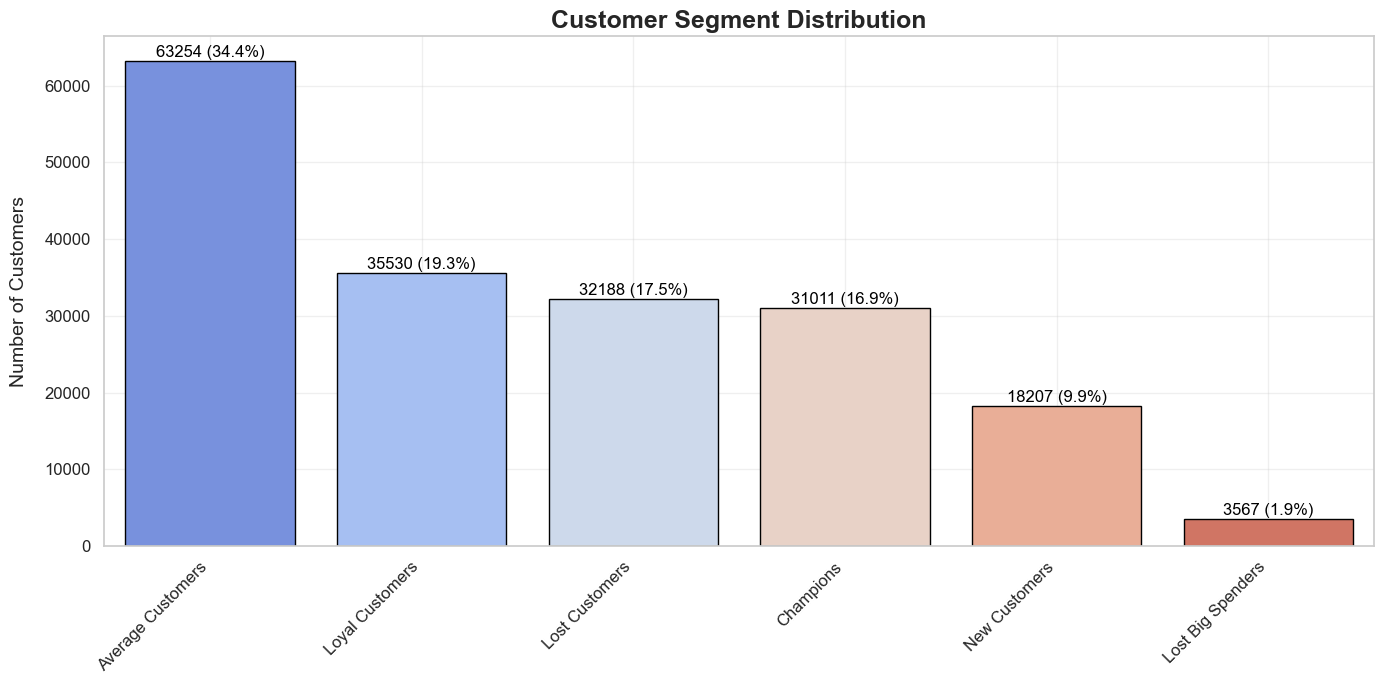

In [4]:
def plot_customer_segment_distribution(segment_distribution):
    
    # Extract segment names and counts
    segments = list(segment_distribution.keys())
    counts = list(segment_distribution.values())
    total_customers = sum(counts)

    # Calculate percentages
    percentages = [count / total_customers * 100 for count in counts]

    # Set seaborn style for aesthetics
    sns.set_theme(style="whitegrid")

    # Create the bar chart
    plt.figure(figsize=(14, 7))
    bars = sns.barplot(x=segments, y=counts, palette="coolwarm", edgecolor="black", hue=None)

    # Add titles and labels
    plt.title('Customer Segment Distribution', fontsize=18, weight='bold')
    plt.ylabel('Number of Customers', fontsize=14, labelpad=12)


    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels above bars
    for bar, count, percentage in zip(bars.patches, counts, percentages):
        height = bar.get_height() + 515
        plt.text(bar.get_x() + bar.get_width() / 2, height + 12, f'{count} ({percentage:.1f}%)',
                 ha='center', fontsize=12, color='black')

    # Make the grid lines more transparent
    plt.grid(visible=True, alpha=0.3)

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

# Assuming you have the `rfm_df` and `summary` from the example usage
rfm_df = calculate_rfm_metrics(transactions_df)
summary = analyze_rfm_results(rfm_df)

# Plot the customer segment distribution
plot_customer_segment_distribution(summary['segment_distribution'])


#### Campaign performance overview

In [24]:
# Convert date columns to datetime
campaigns_df['start_date'] = pd.to_datetime(campaigns_df['start_date'])
campaigns_df['end_date'] = pd.to_datetime(campaigns_df['end_date'])

# Calculate campaign duration
campaigns_df['duration'] = (campaigns_df['end_date'] - campaigns_df['start_date']).dt.days
campaigns_df.head()

,campaign_id,campaign_name,campaign_type,channel,discount_amount,start_date,end_date,budget,target_segment,is_seasonal,duration
0,1,Campaign_1,Free Shipping,Email,20,2022-10-21,2022-10-30,35263.49,Inactive,False,9
1,2,Campaign_2,Free Shipping,Push Notification,15,2022-10-16,2022-11-06,38106.02,New Customers,False,21
2,3,Summer Kickoff,Free Shipping,Display Ads,10,2022-06-04,2022-06-08,12908.32,All,True,4
3,4,Summer Kickoff,Bundle Deal,Display Ads,15,2022-06-09,2022-06-16,10662.53,All,True,7
4,5,Black Friday,BOGO,SMS,25,2022-11-23,2022-11-27,49793.92,Inactive,True,4


##### Basic Campaign Statistics

In [23]:
print("Campaign Statistics:")
print("-------------------")
print("\nCampaign Types:")
print(campaigns_df['campaign_type'].value_counts())

print("\nTarget Segments:")
print(campaigns_df['target_segment'].value_counts())

print("\nChannels Used:")
print(campaigns_df['channel'].value_counts())

print("\nBudget Statistics:")
print(campaigns_df['budget'].describe())

Campaign Statistics:
-------------------

Campaign Types:
campaign_type
BOGO             25
Bundle Deal      21
Free Shipping    15
Discount         13
Flash Sale       11
Name: count, dtype: int64

Target Segments:
target_segment
High Value         23
Inactive           19
All                18
Loyal Customers    13
New Customers      12
Name: count, dtype: int64

Channels Used:
channel
Email                23
Display Ads          22
Push Notification    15
Social Media         13
SMS                  12
Name: count, dtype: int64

Budget Statistics:
count       85.000000
mean     25645.128824
std      13869.977602
min       5152.560000
25%      13868.670000
50%      22457.570000
75%      37918.450000
max      49793.920000
Name: budget, dtype: float64


In [26]:
# Fourth cell - Campaign type analysis
campaign_type_stats = campaigns_df.groupby('campaign_type').agg({
    'campaign_id': 'count',
    'budget': ['mean', 'sum'],
    'discount_amount': 'mean'
}).round(2)

print("Campaign Type Analysis:")
print(campaign_type_stats)

Campaign Type Analysis:
              campaign_id    budget            discount_amount
                    count      mean        sum            mean
campaign_type                                                 
BOGO                   25  25886.21  647155.20           19.00
Bundle Deal            21  28441.95  597281.01           18.81
Discount               13  26065.75  338854.73           20.00
Flash Sale             11  20485.50  225340.47           19.55
Free Shipping          15  24746.97  371204.54           20.33


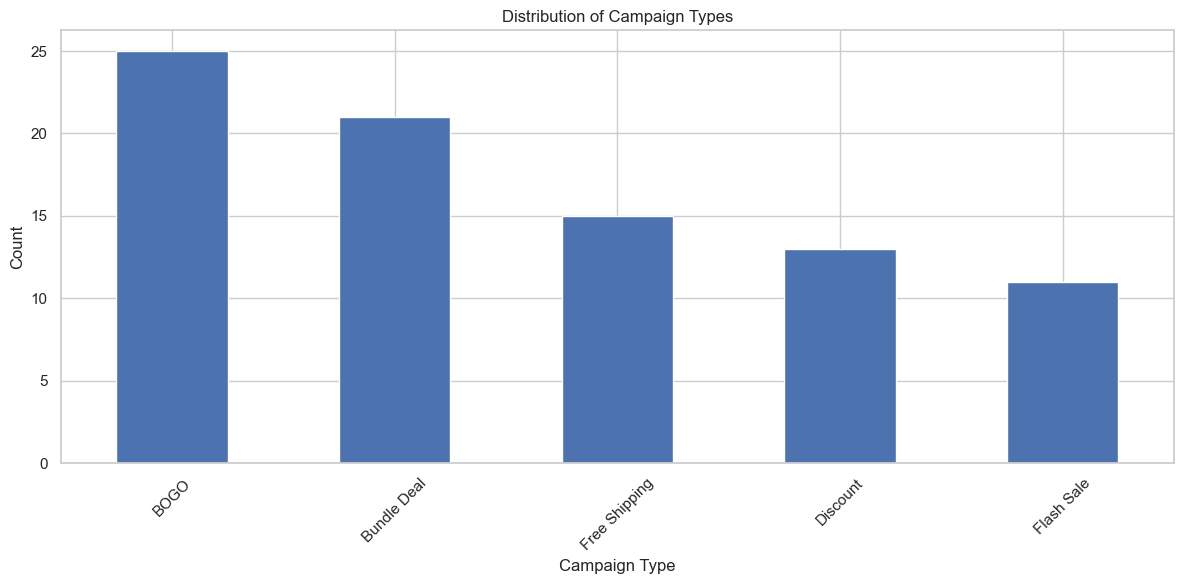

In [27]:
# Fifth cell - Visualization 1: Campaign Distribution
plt.figure(figsize=(12, 6))
campaigns_df['campaign_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Campaign Types')
plt.xlabel('Campaign Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

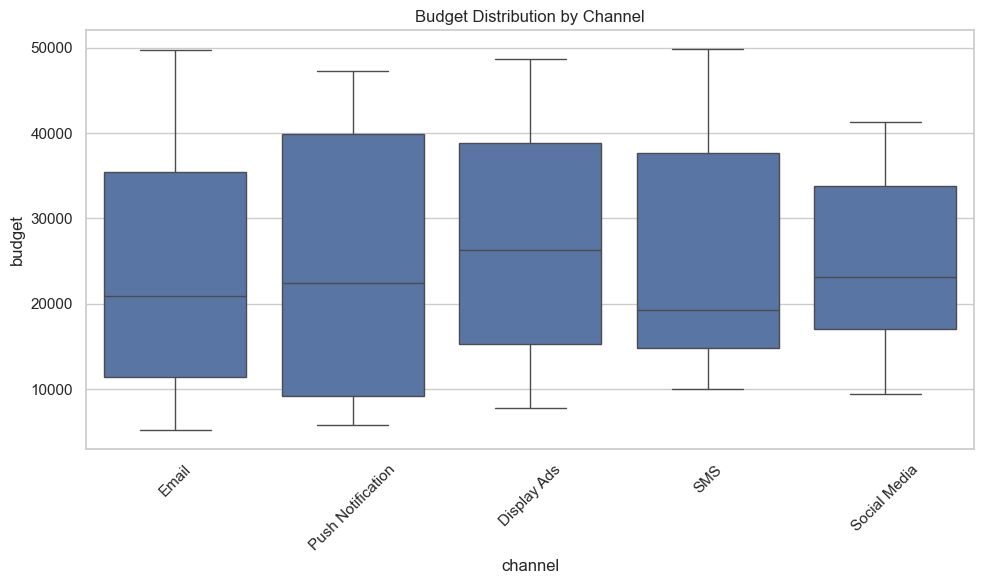

In [28]:
# Sixth cell - Visualization 2: Budget by Channel
plt.figure(figsize=(10, 6))
sns.boxplot(x='channel', y='budget', data=campaigns_df)
plt.title('Budget Distribution by Channel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

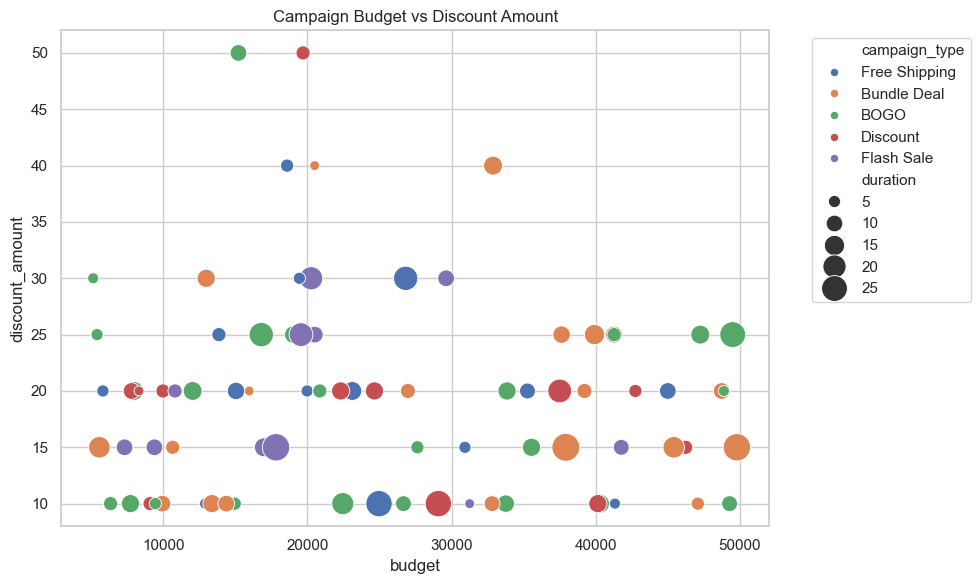

In [29]:
# Seventh cell - Visualization 3: Discount Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=campaigns_df, x='budget', y='discount_amount', 
                hue='campaign_type', size='duration', sizes=(50, 400))
plt.title('Campaign Budget vs Discount Amount')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

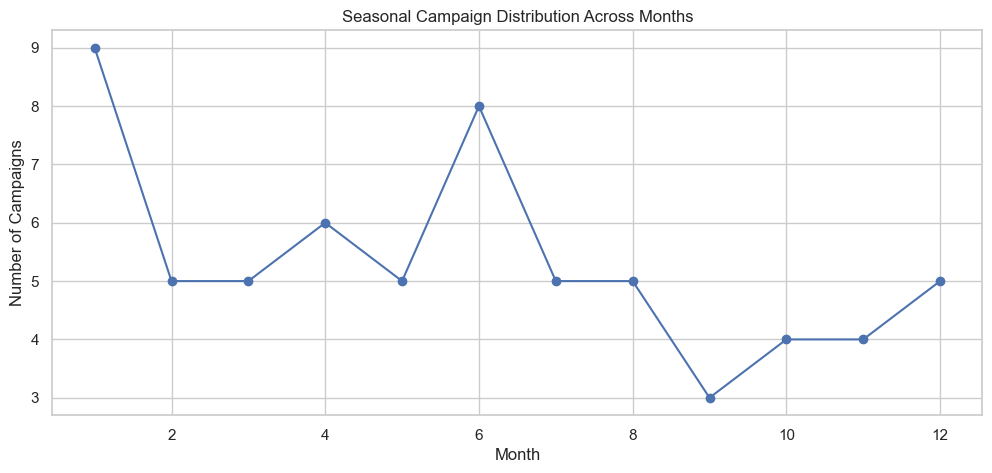

In [30]:
# Eighth cell - Seasonal Analysis
plt.figure(figsize=(12, 5))
seasonal_data = campaigns_df[campaigns_df['is_seasonal']].copy()
seasonal_data['month'] = seasonal_data['start_date'].dt.month

monthly_campaigns = seasonal_data.groupby('month').size()
plt.plot(monthly_campaigns.index, monthly_campaigns.values, marker='o')
plt.title('Seasonal Campaign Distribution Across Months')
plt.xlabel('Month')
plt.ylabel('Number of Campaigns')
plt.grid(True)
plt.show()

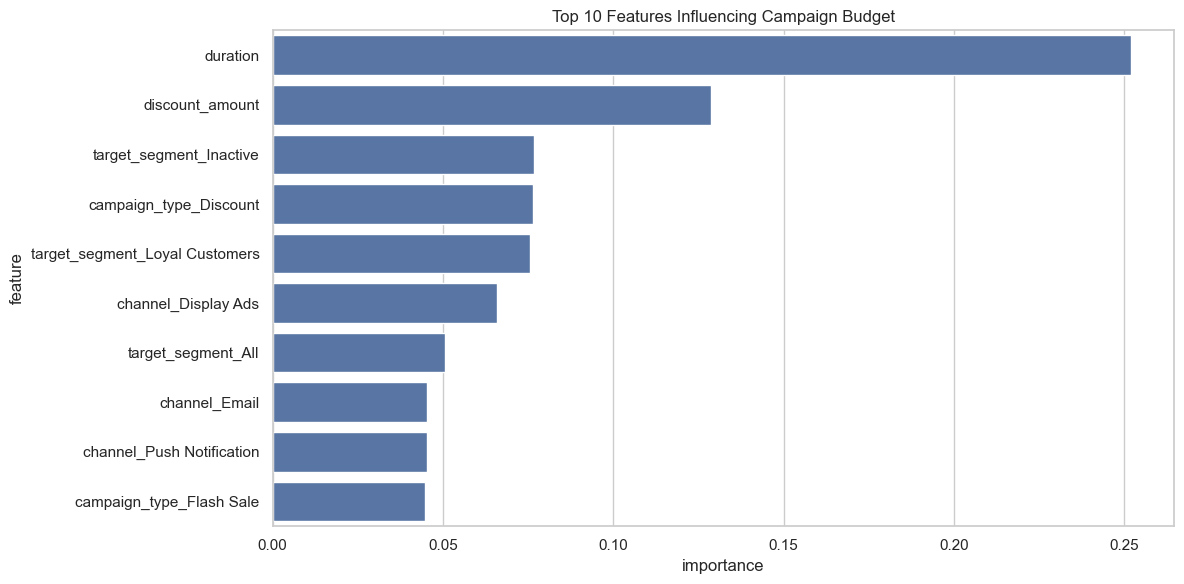

In [31]:
# Ninth cell - Budget Prediction Model
# Prepare features
X = pd.get_dummies(campaigns_df[['campaign_type', 'channel', 'target_segment', 'is_seasonal']])
X['discount_amount'] = campaigns_df['discount_amount']
X['duration'] = campaigns_df['duration']

# Target variable
y = campaigns_df['budget']

# Train model
model = GradientBoostingRegressor(random_state=42)
model.fit(X, y)

# Display feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features Influencing Campaign Budget')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

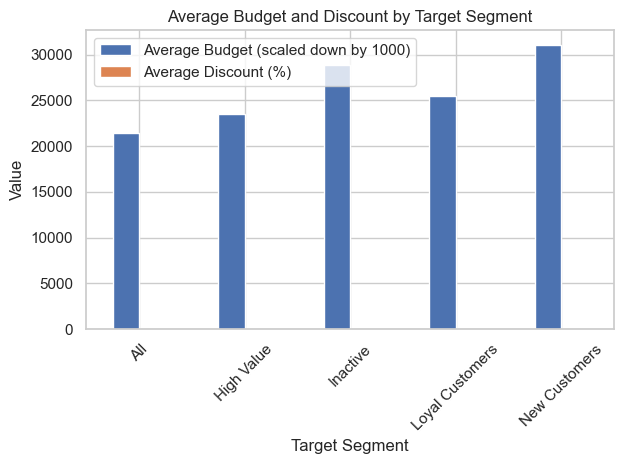

In [32]:
# Tenth cell - Campaign Targeting Analysis
plt.figure(figsize=(12, 6))
target_segment_stats = campaigns_df.groupby('target_segment').agg({
    'budget': 'mean',
    'discount_amount': 'mean'
}).round(2)

target_segment_stats.plot(kind='bar')
plt.title('Average Budget and Discount by Target Segment')
plt.xlabel('Target Segment')
plt.ylabel('Value')
plt.legend(['Average Budget (scaled down by 1000)', 'Average Discount (%)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()